In [1]:
import torch
from torch import nn
from torch.optim import Adam
import numpy as np
from matplotlib import pyplot as plt

torch.manual_seed(10)
np.random.seed(10)
device = 'cpu'

dropout = 0.5
weight_decay = 1e-6     # L2正则化系数
l_square = 0.01         # length-scale，式42、45

In [2]:
# ===== 数据准备
def toy_function(x):
    return x*np.sin(x)

x = torch.randn(100).reshape(-1,1) * 2
y = toy_function(x)
x, y = x.to(device), y.to(device)

In [3]:
# ===== 模型定义
model = nn.Sequential(
            nn.Linear(1,32),
            nn.ReLU(),  # 注意，与bbb模型激活函数不同
            nn.Dropout(dropout),
            nn.Linear(32,16),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(16,1)
        )
# 优化器
opt = Adam(model.parameters(), lr=0.01, weight_decay=weight_decay)
# 损失
loss_fn = nn.MSELoss()

In [4]:
# ===== 训练
epochs = 400
for epoch in range(epochs):
    opt.zero_grad()
    model_out = model(x)
    loss = loss_fn(model_out, y)
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
        print(f'epoch: {epoch:>5}/{epochs:<10} Loss: {loss.item():.6}')

epoch:     0/400        Loss: 2.76068
epoch:   100/400        Loss: 0.912913
epoch:   200/400        Loss: 0.964091
epoch:   300/400        Loss: 0.902915


In [5]:
# ===== 测试、可视化

def tau(dropout, l_square, data_size, weight_decay):
    return l_square * (1. - dropout) / (2. * data_size * weight_decay)          # 式45

In [6]:
model.train()          # 在预测中也使用Dropout
# 测试数据
x_test = torch.linspace(-6, 6, 100).reshape([-1, 1])
y_test = toy_function(x_test)

# 模型预测sample_num次
sample_num = 200
y_preds = [model(x_test.to(device)).detach().cpu() for _ in range(sample_num)]
y_preds = np.array([s.numpy() for s in y_preds]).squeeze(-1)
y_preds_mean = np.mean(y_preds, axis=0)                                         # 式43
t = tau(dropout, l_square, len(x), weight_decay)
y_preds_var = 1/t + np.var(y_preds, axis =0)                                    # 式44
y_preds_std = np.sqrt(y_preds_var)

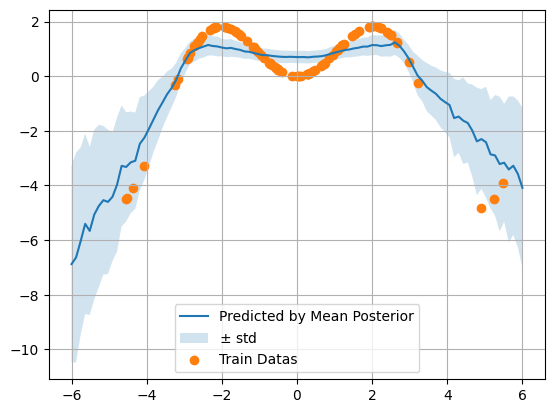

In [7]:
plt.plot(x_test.view(-1), y_preds_mean, label='Predicted by Mean Posterior')    # 平均预测
plt.fill_between(x_test.reshape(-1),
                 y_preds_mean + y_preds_std,
                 y_preds_mean - y_preds_std,
                 alpha = 0.2, label='$\pm$ std')
plt.scatter(x.view(-1), y.view(-1), label='Train Datas')                        # 真实值
plt.legend(loc='lower center')
plt.grid()
plt.show()